In [1]:
from openai import OpenAI
from pydantic import BaseModel

from src.schema import OutputSchema
from src.llm import openai_chat_completion_response


# create client
client = OpenAI(
    api_key='YOUR API KEY',
    max_retries=3,
)


# define output schema as Pydantic class
class SymptomStatus(BaseModel):
    status: bool
    

class SymptomDetail(BaseModel):
    Anxiety: bool
    Concentration_Problems: bool
    Constipation: bool
    Cough: bool
    Diarrhea: bool
    Fatigue: bool
    Fever: bool
    Headache: bool
    Nausea: bool
    Numbness_and_Tingling: bool
    Pain: bool
    Poor_Appetite: bool
    Rash: bool
    Shortness_of_Breath: bool
    Trouble_Drinking_Fluids: bool
    Vomiting: bool
    Other: bool


# helper class OutputSchema deals with the tool/tool_choice specs
status_output_schema = OutputSchema(SymptomStatus, schema_name='symptom_tracker')
detail_output_schema = OutputSchema(SymptomDetail, schema_name='symptom_extractor')

# define system message
status_system_message = "Are any medical symptoms mentioned in the transcript"
detail_system_message = "For each symptom in symptom list return True if present and False if absent from the transcript. All symptoms required. Symptom list: 'anxiety', 'concentration problems', 'constipation', 'cough', 'diarrhea', 'fatigue', 'fever', 'headache', 'nausea', 'numbness and tingling', 'pain', 'poor appetite', 'rash', 'shortness of breath', 'trouble drinking fluids', 'vomiting', 'other'"

# Example 1: Symptom Tracker

In [2]:
%%time
import pandas as pd
import concurrent.futures


# setup
models = ['gpt-4o-mini']
data = pd.read_csv('data/status_data.csv')
input_data = data['text'].tolist()
system_message = status_system_message
output_schema = status_output_schema

for model in models:
    print(model)
    with concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:
        responses = list(
            executor.map(
                lambda p: openai_chat_completion_response(
                    client=client,
                    system_message=system_message,
                    user_message=p,
                    output_schema=output_schema,
                    model=model,
                    max_attempts=5,
                    temperature=0.0,
                ),
                input_data
            )
        )
        
    # Check for mismatch in lengths
    if len(responses) != len(input_data):
        raise ValueError("Mismatch in number of questions and responses")
    
    # Assign responses back to DataFrame
    column_name = f'response_status_{model.replace(".", "_").replace("-", "_")}'
    data[column_name] = responses

gpt-4o-mini
CPU times: user 528 ms, sys: 107 ms, total: 635 ms
Wall time: 2.01 s


In [3]:
# check nulls
from src.utils import check_null_in_response_columns


check_null_in_response_columns(data, prefix='response_status')

Column 'response_status_gpt_4o_mini' has 0 null values.


In [4]:
# convert columns
from src.utils import convert_status_response_columns


data = convert_status_response_columns(data, prefix='response_status_')

In [5]:
# save results
data.to_csv('responses/status_responses.csv', index=False)

# Example 2: Symptom Extractor

In [6]:
%%time
import pandas as pd
import concurrent.futures


# setup
models = ['gpt-4o-mini']
data = pd.read_csv('data/detail_data.csv')
input_data = data['text'].tolist()
system_message = detail_system_message
output_schema = detail_output_schema

for model in models:
    print(model)
    with concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:
        responses = list(
            executor.map(
                lambda p: openai_chat_completion_response(
                    client=client,
                    system_message=system_message,
                    user_message=p,
                    output_schema=output_schema,
                    model=model,
                    max_attempts=5,
                    temperature=0.0,
                ),
                input_data
            )
        )
        
    # Check for mismatch in lengths
    if len(responses) != len(input_data):
        raise ValueError("Mismatch in number of questions and responses")
    
    # Assign responses back to DataFrame
    column_name = f'response_detail_{model.replace(".", "_").replace("-", "_")}'
    data[column_name] = responses

gpt-4o-mini
CPU times: user 324 ms, sys: 42.1 ms, total: 366 ms
Wall time: 8.09 s


In [7]:
# check nulls
from src.utils import check_null_in_response_columns


check_null_in_response_columns(data, prefix='response_detail')

Column 'response_detail_gpt_4o_mini' has 0 null values.


In [8]:
# save results
data.to_csv('responses/detail_responses.csv', index=False)

# Symptom Tracker Metrics and Statistics

In [1]:
import pandas as pd

# load status data with predictions
data = pd.read_csv('responses/status_responses.csv')
data.head()

,text,label,source,pred_status_gpt_3_5_turbo_1106,pred_status_gpt_4_1106_preview,pred_status_gpt_4_0613,pred_status_gpt_4o_2024_05_13
0,"D: How may I help you?\n\nP: Hi, umm, so I've ...",Positive,RES0181.txt,True,True,True,True
1,D: OK. And how about your appetite? Has that c...,Positive,RES0181.txt,True,True,True,True
2,D: OK. Have you had any any headaches?\n\nP: U...,Positive,RES0181.txt,False,False,True,False
3,D: Have you had any abdominal pain?\n\nP: No. ...,Positive,RES0181.txt,True,False,True,True
4,"P: I use an insulin pump, yeah.\n\nD: OK, exce...",Positive,RES0181.txt,False,True,True,True


In [2]:
# cast label to bool
data['label'] = data['label'].map({'Positive': True, 'Negative': False})

In [3]:
# Cochran's Q test
from src.stats import cochrans_q_test


q_stat, p_value = cochrans_q_test(
    data, pred_prefix='pred_status_', label_column='label'
)

print(f"Cochran's Q statistic: {q_stat}")
print(f"P-value: {p_value}")

Cochran's Q statistic: 581.0620373634121
P-value: 1.2846315166785642e-125


In [5]:
# McNemar's pairwise test
from src.stats import mcnemar_pairwise


# perform pairwise McNemar tests
pairwise_results = mcnemar_pairwise(
    data, pred_prefix='pred_status_', label_column='label'
)

# display the results
for comparison, (statistic, p_value) in pairwise_results.items():
    print(f'{comparison}:')
    print(f'\tstatistic = {statistic}')
    print(f'\tp-value = {p_value}')

gpt_3_5_turbo_1106_correct vs gpt_4_1106_preview_correct:
	statistic = 227.0
	p-value = 2.9436715096186093e-05
gpt_3_5_turbo_1106_correct vs gpt_4_0613_correct:
	statistic = 98.0
	p-value = 2.671855655710762e-64
gpt_3_5_turbo_1106_correct vs gpt_4o_2024_05_13_correct:
	statistic = 153.0
	p-value = 0.0006134517697632293
gpt_4_1106_preview_correct vs gpt_4_0613_correct:
	statistic = 28.0
	p-value = 5.021226748167029e-119
gpt_4_1106_preview_correct vs gpt_4o_2024_05_13_correct:
	statistic = 86.0
	p-value = 4.814626941401267e-20
gpt_4_0613_correct vs gpt_4o_2024_05_13_correct:
	statistic = 52.0
	p-value = 1.1712662582103174e-62


In [7]:
# Bonferroni correction
alpha = 0.05
corrected_alpha = alpha / len(pairwise_results)

for comparison, (statistic, p_value) in pairwise_results.items():
    is_significant = p_value < corrected_alpha
    print(f'{comparison}:')
    print(f'\tstatistic = {statistic}')
    print(f'\tp-value = {p_value}')
    print(f'\tsignificant = {is_significant}')

gpt_3_5_turbo_1106_correct vs gpt_4_1106_preview_correct:
	statistic = 227.0
	p-value = 2.9436715096186093e-05
	significant = True
gpt_3_5_turbo_1106_correct vs gpt_4_0613_correct:
	statistic = 98.0
	p-value = 2.671855655710762e-64
	significant = True
gpt_3_5_turbo_1106_correct vs gpt_4o_2024_05_13_correct:
	statistic = 153.0
	p-value = 0.0006134517697632293
	significant = True
gpt_4_1106_preview_correct vs gpt_4_0613_correct:
	statistic = 28.0
	p-value = 5.021226748167029e-119
	significant = True
gpt_4_1106_preview_correct vs gpt_4o_2024_05_13_correct:
	statistic = 86.0
	p-value = 4.814626941401267e-20
	significant = True
gpt_4_0613_correct vs gpt_4o_2024_05_13_correct:
	statistic = 52.0
	p-value = 1.1712662582103174e-62
	significant = True


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_bootstrap(df, prediction_columns: list[str], label_column: str, n_iterations=1000, confidence_level=0.95):
    results = []

    for col in prediction_columns:
        metrics = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "f1": []
        }
        
        n = len(df)
        
        for i in range(n_iterations):
            # Bootstrap sampling
            bootstrap_sample = df.sample(n=n, replace=True)
            
            y_true = bootstrap_sample[label_column]
            y_pred = bootstrap_sample[col].astype(bool)
    
            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
            # Append metrics
            metrics["accuracy"].append(accuracy)
            metrics["precision"].append(precision)
            metrics["recall"].append(recall)
            metrics["f1"].append(f1)
        
        # Calculate mean and confidence intervals
        col_results = {}
        for metric, values in metrics.items():
            mean = np.mean(values)
            lower_bound = np.percentile(values, (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(values, (1 + confidence_level) / 2 * 100)
            col_results[metric] = {
                "mean": mean,
                "95% CI": (lower_bound, upper_bound)
            }
        
        results.append({
            "prediction_column": col,
            "metrics": col_results
        })
    
    return results

# Example usage:
# Define the prediction columns
prediction_columns = [col for col in data.columns if col.startswith('pred_status_')]

# Evaluate
result = evaluate_bootstrap(
    data,
    prediction_columns=prediction_columns,
    label_column='label',
)

for res in result:
     print(f"Results for {res['prediction_column']}:")
     for metric, values in res['metrics'].items():
         print(f"  {metric}: Mean = {values['mean']:.4f}, 95% CI = {values['95% CI'][0]:.4f} to {values['95% CI'][1]:.4f}")
     print()

Results for pred_status_gpt_3_5_turbo_1106:
  accuracy: Mean = 0.7841, 95% CI = 0.7689 to 0.7984
  precision: Mean = 0.8704, 95% CI = 0.8556 to 0.8851
  recall: Mean = 0.7998, 95% CI = 0.7830 to 0.8161
  f1: Mean = 0.8335, 95% CI = 0.8202 to 0.8458

Results for pred_status_gpt_4_1106_preview:
  accuracy: Mean = 0.7521, 95% CI = 0.7374 to 0.7666
  precision: Mean = 0.7762, 95% CI = 0.7610 to 0.7924
  recall: Mean = 0.8902, 95% CI = 0.8758 to 0.9025
  f1: Mean = 0.8293, 95% CI = 0.8178 to 0.8402

Results for pred_status_gpt_4_0613:
  accuracy: Mean = 0.9121, 95% CI = 0.9024 to 0.9209
  precision: Mean = 0.8979, 95% CI = 0.8864 to 0.9099
  recall: Mean = 0.9816, 95% CI = 0.9757 to 0.9867
  f1: Mean = 0.9379, 95% CI = 0.9310 to 0.9445

Results for pred_status_gpt_4o_2024_05_13:
  accuracy: Mean = 0.8065, 95% CI = 0.7932 to 0.8201
  precision: Mean = 0.8465, 95% CI = 0.8322 to 0.8622
  recall: Mean = 0.8723, 95% CI = 0.8570 to 0.8871
  f1: Mean = 0.8592, 95% CI = 0.8484 to 0.8703


In [10]:
def create_df(result):
    # Extract data for CSV
    columns = []
    precisions = []
    recalls = []
    accuracies = []
    f1_scores = []
    
    for res in result:
        columns.append(res['prediction_column'])
        precisions.append(f"{res['metrics']['precision']['mean']:.2f} ({res['metrics']['precision']['95% CI'][0]:.2f}–{res['metrics']['precision']['95% CI'][1]:.2f})")
        recalls.append(f"{res['metrics']['recall']['mean']:.2f} ({res['metrics']['recall']['95% CI'][0]:.2f}–{res['metrics']['recall']['95% CI'][1]:.2f})")
        accuracies.append(f"{res['metrics']['accuracy']['mean']:.2f} ({res['metrics']['accuracy']['95% CI'][0]:.2f}–{res['metrics']['accuracy']['95% CI'][1]:.2f})")
        f1_scores.append(f"{res['metrics']['f1']['mean']:.2f} ({res['metrics']['f1']['95% CI'][0]:.2f}–{res['metrics']['f1']['95% CI'][1]:.2f})")
    
    # Create a DataFrame
    df = pd.DataFrame({
        "Model": columns,
        "Precision": precisions,
        "Recall": recalls,
        "Accuracy": accuracies,
        "F1 Score": f1_scores
    })

    return df


fig_df=create_df(result)
fig_df.head(10)

,Model,Precision,Recall,Accuracy,F1 Score
0,pred_status_gpt_3_5_turbo_1106,0.87 (0.86–0.89),0.80 (0.78–0.82),0.78 (0.77–0.80),0.83 (0.82–0.85)
1,pred_status_gpt_4_1106_preview,0.78 (0.76–0.79),0.89 (0.88–0.90),0.75 (0.74–0.77),0.83 (0.82–0.84)
2,pred_status_gpt_4_0613,0.90 (0.89–0.91),0.98 (0.98–0.99),0.91 (0.90–0.92),0.94 (0.93–0.94)
3,pred_status_gpt_4o_2024_05_13,0.85 (0.83–0.86),0.87 (0.86–0.89),0.81 (0.79–0.82),0.86 (0.85–0.87)


# Symptom Extraction Metrics and Statistics

In [1]:
import pandas as pd

# load status data with predictions
data = pd.read_csv('responses/detail_responses.csv')
data.head()

,text,label,source,response_detail_gpt_3_5_turbo_1106,response_detail_gpt_4_1106_preview,response_detail_gpt_4_0613,response_detail_gpt_4o_2024_05_13
0,"D: How may I help you?\n\nP: Hi, umm, so I've ...",fever;other;trouble drinking fluids,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F..."
1,D: OK. And how about your appetite? Has that c...,fever;other;poor appetite,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F..."
2,D: OK. Have you had any any headaches?\n\nP: U...,cough;headache;nausea;other;pain;shortness of ...,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F..."
3,D: Have you had any abdominal pain?\n\nP: No. ...,constipation;diarrhea;fatigue;other;pain;rash,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F..."
4,"P: I use an insulin pump, yeah.\n\nD: OK, exce...",anxiety,RES0181.txt,"{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa..."


In [2]:
# convert columns
from src.utils import convert_detail_response_columns, convert_label_column


# Your list of allowed symptoms
allowed_symptoms = [
    'anxiety', 'concentration problems', 'constipation', 'cough', 'diarrhea', 'fatigue', 
    'fever', 'headache', 'nausea', 'numbness and tingling', 'pain', 'poor appetite',
    'rash', 'shortness of breath', 'trouble drinking fluids', 'vomiting', 'other',
]

data = convert_detail_response_columns(data, prefix='response_detail_')
data = convert_label_column(data, label_column='label', allowed_symptoms=allowed_symptoms)
data.head()

,text,label,source,response_detail_gpt_3_5_turbo_1106,response_detail_gpt_4_1106_preview,response_detail_gpt_4_0613,response_detail_gpt_4o_2024_05_13,anxiety_gpt_3_5_turbo_1106,concentration_problems_gpt_3_5_turbo_1106,constipation_gpt_3_5_turbo_1106,...,headache_gs,nausea_gs,numbness_and_tingling_gs,pain_gs,poor_appetite_gs,rash_gs,shortness_of_breath_gs,trouble_drinking_fluids_gs,vomiting_gs,other_gs
0,"D: How may I help you?\n\nP: Hi, umm, so I've ...",fever;other;trouble drinking fluids,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,D: OK. And how about your appetite? Has that c...,fever;other;poor appetite,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,D: OK. Have you had any any headaches?\n\nP: U...,cough;headache;nausea;other;pain;shortness of ...,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,True,True,False,True,False,False,True,False,True,True
3,D: Have you had any abdominal pain?\n\nP: No. ...,constipation;diarrhea;fatigue;other;pain;rash,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,False,False,False,True,False,True,False,False,False,True
4,"P: I use an insulin pump, yeah.\n\nD: OK, exce...",anxiety,RES0181.txt,"{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...",True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
from src.metrics import calculate_model_metrics, combine_metrics_df


models = [
    'gpt_3_5_turbo_1106',
    'gpt_4_1106_preview',
    'gpt_4_0613',
    'gpt_4o_2024_05_13',
]
standardized_symptoms=[
    'anxiety', 'concentration_problems', 'constipation', 'cough', 'diarrhea', 'fatigue', 
    'fever', 'headache', 'nausea', 'numbness_and_tingling', 'pain', 'poor_appetite', 
    'rash', 'shortness_of_breath', 'trouble_drinking_fluids', 'vomiting', 'other'
]

# Calculate metrics
all_metrics = calculate_model_metrics(
    data,
    models=models,
    standardized_symptoms=standardized_symptoms,
)

# Combine metrics into a single DataFrame
combined_df = combine_metrics_df(
    all_metrics, models
).round(2)

# Display the combined DataFrame
combined_df

,symptom,precision,recall,accuracy,f1,model
0,anxiety,0.14,0.71,0.97,0.24,gpt_3_5_turbo_1106
1,concentration_problems,0.25,1.00,0.99,0.40,gpt_3_5_turbo_1106
2,constipation,0.83,0.09,0.95,0.16,gpt_3_5_turbo_1106
3,cough,0.92,0.86,0.93,0.89,gpt_3_5_turbo_1106
4,diarrhea,0.89,0.18,0.93,0.30,gpt_3_5_turbo_1106
...,...,...,...,...,...,...
63,rash,0.98,0.20,0.92,0.33,gpt_4o_2024_05_13
64,shortness_of_breath,0.95,0.65,0.91,0.78,gpt_4o_2024_05_13
65,trouble_drinking_fluids,0.33,0.15,0.99,0.21,gpt_4o_2024_05_13
66,vomiting,1.00,0.10,0.90,0.19,gpt_4o_2024_05_13


In [4]:
from src.metrics import calculate_model_metrics_with_bootstrap, combine_bootstrapped_metrics_df


models = [
    'gpt_3_5_turbo_1106',
    'gpt_4_1106_preview',
    'gpt_4_0613',
    'gpt_4o_2024_05_13',
]
standardized_symptoms=[
    'anxiety', 'concentration_problems', 'constipation', 'cough', 'diarrhea', 'fatigue', 
    'fever', 'headache', 'nausea', 'numbness_and_tingling', 'pain', 'poor_appetite', 
    'rash', 'shortness_of_breath', 'trouble_drinking_fluids', 'vomiting', 'other'
]

# Calculate metrics
all_metrics = calculate_model_metrics_with_bootstrap(data, models, standardized_symptoms, deterministic=True)

# Combine metrics into a single DataFrame
combined_df = combine_bootstrapped_metrics_df(all_metrics, models).round(2)

# Display the combined DataFrame
combined_df

,symptom,metric,mean,95% CI lower,95% CI upper,model
0,anxiety,precision,0.14,0.06,0.23,gpt_3_5_turbo_1106
1,anxiety,recall,0.71,0.44,0.93,gpt_3_5_turbo_1106
2,anxiety,accuracy,0.97,0.96,0.98,gpt_3_5_turbo_1106
3,anxiety,f1,0.23,0.11,0.36,gpt_3_5_turbo_1106
4,concentration_problems,precision,0.25,0.07,0.47,gpt_3_5_turbo_1106
...,...,...,...,...,...,...
63,vomiting,f1,0.19,0.13,0.25,gpt_4o_2024_05_13
64,other,precision,0.87,0.85,0.90,gpt_4o_2024_05_13
65,other,recall,0.39,0.36,0.42,gpt_4o_2024_05_13
66,other,accuracy,0.51,0.49,0.53,gpt_4o_2024_05_13


In [5]:
from src.metrics import create_symptom_df_from_df


symptom_fig_df = create_symptom_df_from_df(combined_df)
symptom_fig_df

,Symptom,Model,Precision,Recall,Accuracy,F1 Score
0,anxiety,gpt_3_5_turbo_1106,0.14 (0.06–0.23),0.71 (0.44–0.93),0.97 (0.96–0.98),0.23 (0.11–0.36)
1,anxiety,gpt_4_0613,0.23 (0.12–0.34),0.87 (0.69–1.00),0.98 (0.97–0.98),0.36 (0.21–0.50)
2,anxiety,gpt_4_1106_preview,0.26 (0.14–0.39),0.80 (0.58–1.00),0.98 (0.98–0.99),0.38 (0.24–0.53)
3,anxiety,gpt_4o_2024_05_13,0.42 (0.24–0.62),0.74 (0.50–0.94),0.99 (0.99–0.99),0.53 (0.35–0.70)
4,concentration_problems,gpt_3_5_turbo_1106,0.25 (0.07–0.47),,0.99 (0.99–1.00),
...,...,...,...,...,...,...
63,trouble_drinking_fluids,gpt_4o_2024_05_13,0.34 (0.08–0.62),0.15 (0.03–0.30),0.99 (0.98–0.99),
64,vomiting,gpt_3_5_turbo_1106,0.97 (0.89–1.00),0.14 (0.10–0.19),0.91 (0.90–0.92),0.25 (0.18–0.32)
65,vomiting,gpt_4_0613,1.00 (1.00–1.00),0.11 (0.07–0.15),0.90 (0.89–0.92),0.19 (0.13–0.26)
66,vomiting,gpt_4_1106_preview,0.92 (0.81–1.00),0.11 (0.07–0.15),0.90 (0.89–0.91),0.19 (0.13–0.26)


# Hallucination

In [6]:
import pandas as pd

from src.utils import convert_detail_response_columns, convert_label_column


# load status data with predictions
data = pd.read_csv('responses/detail_responses.csv')

# Your list of allowed symptoms
allowed_symptoms = [
    'anxiety', 'concentration problems', 'constipation', 'cough', 'diarrhea', 'fatigue', 
    'fever', 'headache', 'nausea', 'numbness and tingling', 'pain', 'poor appetite',
    'rash', 'shortness of breath', 'trouble drinking fluids', 'vomiting', 'other',
]

# convert columns
data = convert_detail_response_columns(data, prefix='response_detail_')
data = convert_label_column(data, label_column='label', allowed_symptoms=allowed_symptoms)
data.head()

,text,label,source,response_detail_gpt_3_5_turbo_1106,response_detail_gpt_4_1106_preview,response_detail_gpt_4_0613,response_detail_gpt_4o_2024_05_13,anxiety_gpt_3_5_turbo_1106,concentration_problems_gpt_3_5_turbo_1106,constipation_gpt_3_5_turbo_1106,...,headache_gs,nausea_gs,numbness_and_tingling_gs,pain_gs,poor_appetite_gs,rash_gs,shortness_of_breath_gs,trouble_drinking_fluids_gs,vomiting_gs,other_gs
0,"D: How may I help you?\n\nP: Hi, umm, so I've ...",fever;other;trouble drinking fluids,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,D: OK. And how about your appetite? Has that c...,fever;other;poor appetite,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,D: OK. Have you had any any headaches?\n\nP: U...,cough;headache;nausea;other;pain;shortness of ...,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,True,True,False,True,False,False,True,False,True,True
3,D: Have you had any abdominal pain?\n\nP: No. ...,constipation;diarrhea;fatigue;other;pain;rash,RES0181.txt,"{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...","{'Anxiety': False, 'Concentration_Problems': F...",False,False,False,...,False,False,False,True,False,True,False,False,False,True
4,"P: I use an insulin pump, yeah.\n\nD: OK, exce...",anxiety,RES0181.txt,"{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...","{'Anxiety': True, 'Concentration_Problems': Fa...",True,False,False,...,False,False,False,False,False,False,False,False,False,False


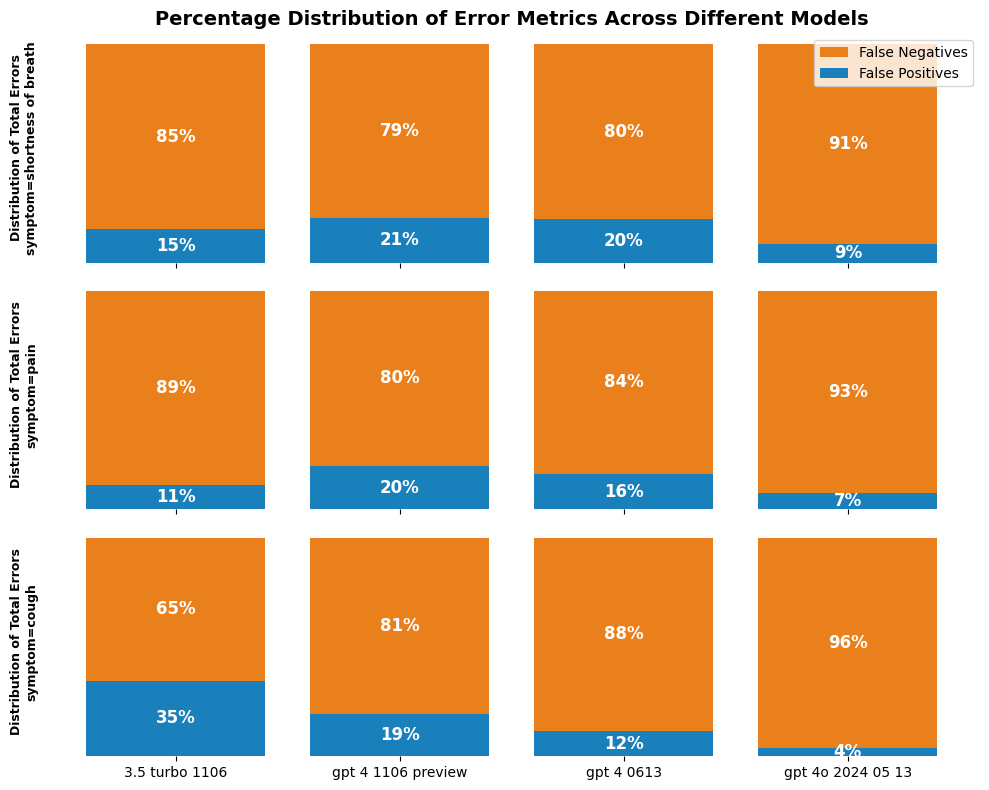

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def get_error_data(
    df: pd.DataFrame,
    symptom: str,
    model_versions: list[str],
    label_suffix: str = '_gs',
):
    results = {}
    for model_version in model_versions:
        # Construct column names based on symptom and model version
        pred_col = f'{symptom}_{model_version}'
        gs_col = f'{symptom}{label_suffix}'

        # Calculate FP, FN
        fp = ((df[pred_col] == True) & (df[gs_col] == False)).sum()
        fn = ((df[pred_col] == False) & (df[gs_col] == True)).sum()

        # Store results
        results[model_version] = {'FP': fp, 'FN': fn}

    return results


def plot_hallucination_bars(ax, categories, fp_percentages, fn_percentages, symptom):
    # Add the stacked bar chart
    ax.bar(categories, fn_percentages, bottom=fp_percentages, label='False Negatives', color='#ea801c', edgecolor='none')
    ax.bar(categories, fp_percentages, label='False Positives', color='#1a80bb', edgecolor='none')

    # Format the y-axis to show percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add labels and title
    ax.set_ylabel(f'Distribution of Total Errors\nsymptom={symptom.replace("_", " ")}', fontsize=9, fontweight='bold')
    
    # Add data labels inside bars
    for cat, fp, fn in zip(categories, fp_percentages, fn_percentages):
        ax.text(cat, fp/2, '{:.0f}%'.format(fp), ha='center', va='center', fontsize=12, color='white', fontweight='bold')
        ax.text(cat, fp + fn/2, '{:.0f}%'.format(fn), ha='center', va='center', fontsize=12, color='white', fontweight='bold')
    
    # Remove spines and y-axis ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_yticks([])  # Remove y-axis ticks

    # Set x-axis labels (but keep them visible)
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, ha='center', fontsize=10)  # Display model names below bars

# Create the figure and the axes
symptoms_of_interest = ['shortness_of_breath', 'pain', 'cough']
model_versions = ['gpt_3_5_turbo_1106', 'gpt_4_1106_preview', 'gpt_4_0613', 'gpt_4o_2024_05_13']

fig, axs = plt.subplots(nrows=len(symptoms_of_interest), figsize=(10, 8), sharex=True, sharey=True)
for i, symptom in enumerate(symptoms_of_interest):
    error_data = get_error_data(
        data,
        symptom=symptom,
        model_versions=model_versions
    )

    # Prepare the data for plotting
    #categories = [cat.replace('_', ' ') for cat in error_data.keys()]  # Replace underscores in model names
    categories = [cat.replace('_', ' ') if cat != 'gpt_3_5_turbo_1106' else '3.5 turbo 1106' for cat in error_data.keys()]

    fp_percentages = [error_data[cat]['FP'] / (error_data[cat]['FP'] + error_data[cat]['FN']) * 100 for cat in error_data.keys()]
    fn_percentages = [error_data[cat]['FN'] / (error_data[cat]['FP'] + error_data[cat]['FN']) * 100 for cat in error_data.keys()]

    # Plot the data
    plot_hallucination_bars(axs[i], categories, fp_percentages, fn_percentages, symptom=symptom)

axs[0].set_title('Percentage Distribution of Error Metrics Across Different Models', fontsize=14, fontweight='bold')
axs[0].legend(frameon=True)

# Adjust layout for tight fitting and save the figure if needed
plt.tight_layout()
# plt.savefig('error_distribution_chart.png', dpi=300) # Uncomment to save the figure

# Show the plot
plt.show()
